In [1]:
pip install pgeocode -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
# import pgeocode
from tqdm.notebook import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

In [3]:
%cd /kaggle/input/hack228/train_dataset_train/train

/kaggle/input/hack228/train_dataset_train/train


In [6]:
data_account = pd.read_csv('cntrbtrs.csv', sep=';')
data_train = pd.read_csv('train.csv')
data_transaction = pd.read_csv('trnsctns.csv', sep=';')

# Избавимся от дубликатов

In [6]:
def union_npo(df):
    df = df.drop_duplicates()
    temp = df.groupby(['quarter','npo_account_id'])['client_id'].count()
    temp = temp[temp > 1].reset_index()
    for i in range(temp.shape[0]):
        npo_account_id = temp.iloc[i]['npo_account_id']
        quarter = temp.iloc[i]['quarter']
        df.loc[(df.npo_account_id == npo_account_id) & (df.quarter == quarter), 'churn'] = 1
    df = df.drop_duplicates()
    return df

data_train = union_npo(data_train)

# Получим агрегации

In [7]:
grouped = data_transaction.drop(columns=['slctn_nmbr', 'year', 'npo_oprtn_date']).groupby(['npo_account_id', 'quarter'])
result = grouped.agg({'npo_sum': ['min', 'max', 'mean', 'count', 'sum'], 
                      'npo_oprtn_grp': ['min', 'max', 'mean', 'count', 'sum']})

result.columns = ['_'.join(col).strip() for col in result.columns.values]
for i in tqdm(range(1, 5)):
    for stat in ['min', 'max', 'mean', 'count', 'sum']:
        result[f'{stat}_npo_sum_{i}_quarters_ago'] = result.groupby('npo_account_id')[f'npo_sum_{stat}'].shift(i)
        result[f'{stat}_npo_oprtn_grp_{i}_quarters_ago'] = result.groupby('npo_account_id')[f'npo_oprtn_grp_{stat}'].shift(i)
data_train = data_train.merge(result, on=['npo_account_id', 'quarter'], how='left')

In [49]:
data_train.drop(columns=['npo_sum_min','npo_sum_max','npo_sum_mean','npo_sum_count',
                         'npo_sum_sum','npo_oprtn_grp_min','npo_oprtn_grp_max','npo_oprtn_grp_mean',
                         'npo_oprtn_grp_count','npo_oprtn_grp_sum'], inplace=True)

In [8]:
data_train[['year', 'quarter_number']] = data_train['quarter'].str.split('Q', expand=True)
data_train['quarter_sin'] = np.sin(2 * np.pi * data_train['quarter_number'].astype(float) / 4)
data_train['quarter_cos'] = np.cos(2 * np.pi * data_train['quarter_number'].astype(float) / 4)

In [22]:
data_train

,slctn_nmbr,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,balance,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt_date,lst_pmnt_date_per_qrtr,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,pmnts_sum_per_qrtr,pmnts_sum_per_year,pmnts_nmbr_per_qrtr,pmnts_nmbr_per_year,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,postal_code,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_max,npo_sum_mean,npo_sum_count,npo_sum_sum,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_mean,npo_oprtn_grp_count,npo_oprtn_grp_sum,min_npo_sum_1_quarters_ago,min_npo_oprtn_grp_1_quarters_ago,max_npo_sum_1_quarters_ago,max_npo_oprtn_grp_1_quarters_ago,mean_npo_sum_1_quarters_ago,mean_npo_oprtn_grp_1_quarters_ago,count_npo_sum_1_quarters_ago,count_npo_oprtn_grp_1_quarters_ago,sum_npo_sum_1_quarters_ago,sum_npo_oprtn_grp_1_quarters_ago,min_npo_sum_2_quarters_ago,min_npo_oprtn_grp_2_quarters_ago,max_npo_sum_2_quarters_ago,max_npo_oprtn_grp_2_quarters_ago,mean_npo_sum_2_quarters_ago,mean_npo_oprtn_grp_2_quarters_ago,count_npo_sum_2_quarters_ago,count_npo_oprtn_grp_2_quarters_ago,sum_npo_sum_2_quarters_ago,sum_npo_oprtn_grp_2_quarters_ago,min_npo_sum_3_quarters_ago,min_npo_oprtn_grp_3_quarters_ago,max_npo_sum_3_quarters_ago,max_npo_oprtn_grp_3_quarters_ago,mean_npo_sum_3_quarters_ago,mean_npo_oprtn_grp_3_quarters_ago,count_npo_sum_3_quarters_ago,count_npo_oprtn_grp_3_quarters_ago,sum_npo_sum_3_quarters_ago,sum_npo_oprtn_grp_3_quarters_ago,min_npo_sum_4_quarters_ago,min_npo_oprtn_grp_4_quarters_ago,max_npo_sum_4_quarters_ago,max_npo_oprtn_grp_4_quarters_ago,mean_npo_sum_4_quarters_ago,mean_npo_oprtn_grp_4_quarters_ago,count_npo_sum_4_quarters_ago,count_npo_oprtn_grp_4_quarters_ago,sum_npo_sum_4_quarters_ago,sum_npo_oprtn_grp_4_quarters_ago,quarter_number,quarter_sin,quarter_cos
0,1,0xA095932790098744A2325A8D152C05C7,0xD4DBBAC6561929409BA45725A220613E,1,2,2017,2017Q4,1,48,8091,0,6757,679.37,31.34,31.34,1999-07-02,NaN,96.25,0.09,96.25,1,-0.00,-0.00,0,0,583.12,31.34,31.34,1.8,1.8,0,0,-1,-1,-1,446254.0,САМАРСКАЯ ОБЛ,-1,-1,0,0,0,31.34,31.34,31.3400,1.0,31.34,0.0,0.0,0.00,1.0,0.0,51.60,0.0,51.60,0.0,51.600000,0.00,1.0,1.0,51.60,0.0,16.61,0.0,39.38,0.0,27.995000,0.0,2.0,2.0,55.99,0.0,52.76,0.0,52.76,0.0,52.760000,0.0,1.0,1.0,52.76,0.0,45.53,0.0,45.53,0.0,45.530000,0.00,1.0,1.0,45.53,0.0,4,-2.449294e-16,1.000000e+00
1,0,0xF75BAA20A603A2479005DEB80464336E,0x3DCFF11974B3D8458CE3569DE9E855D5,2,2,2009,2009Q1,1,35,3303,1531,34,36395.87,1457.59,8037.71,2004-12-31,2009-03-11,9823.67,607.40,28402.25,52,1457.58,5474.56,3,12,7993.61,-0.00,2563.14,0.0,0.0,-1,0,-1,-1,-1,399841.0,ЛИПЕЦКАЯ ОБЛ,-1,1,0,1,0,354.57,579.58,485.8600,3.0,1457.58,1.0,1.0,1.00,3.0,3.0,424.21,0.0,1314.39,1.0,673.012500,0.75,4.0,4.0,2692.05,3.0,247.01,1.0,455.17,1.0,327.410000,1.0,3.0,3.0,982.23,3.0,395.61,1.0,456.85,1.0,422.863333,1.0,3.0,3.0,1268.59,3.0,206.34,1.0,526.59,1.0,338.936667,1.00,3.0,3.0,1016.81,3.0,1,1.000000e+00,6.123234e-17
2,2,0x0D18081E0556AF4F95A931FBA4159D52,0x9DADF88CB3407C4E89403315F640393E,1,1,2010,2010Q1,1,47,1163,1121,34,5569.85,463.41,1953.00,2007-02-20,2010-03-17,154.47,154.47,5406.50,35,463.41,1699.18,3,11,163.35,-0.00,253.81,0.1,0.1,-1,-1,-1,-1,-1,302038.0,ОРЛОВСКАЯ ОБЛ,1,1,0,1,0,154.47,154.47,154.4700,3.0,463.41,1.0,1.0,1.00,3.0,3.0,4.14,0.0,154.47,1.0,94.824000,0.60,5.0,5.0,474.12,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,3.0,3.0,463.41,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,2.0,2.0,308.94,2.0,154.47,1.0,154.47,1.0,154.470000,1.00,3.0,3.0,463.41,3.0,1,1.000000e+00,6.123234e-17
3,0,0x0AD72BC5475D9A4D83E12350A84F839D,0xF59C4E62F115684899EAE9B5D5ECF70F,1,1,2005,2005Q4,-1,42,47,0,0,81.37,81.37,81.37,2005-12-29,2005-12-29,81.30,81.30,81.30,1,81.30,81.30,1,1,0.06,0.06,0.06,4.0,4.0,-1,0,-1,-1,-1,620034.0,СВЕРДЛОВСКАЯ ОБЛ,1,1,0,1,0,0.06,81.30,40.6800,2.0,81.36,0.0,1.0,0.50,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Координаты

In [16]:
coordinates_df = pd.read_csv('/kaggle/input/hack228/coordinates.csv')
coordinates_df.head(2)

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,446254,RU,Безенчук 4,Самарская Область,65.0,БЕЗЕНЧУКСКИЙ РАЙОН,NaN,NaN,NaN,52.9800,49.4200,1.0
1,399841,RU,Бигильдино,Липецкая Область,43.0,ДАНКОВСКИЙ РАЙОН,NaN,NaN,NaN,53.3569,39.1503,4.0


In [23]:
data_train = data_train.merge(coordinates_df[['postal_code', 'latitude','longitude', 'county_name', 'state_name']], on=['postal_code'], how='left')

# Центральная ставка

In [27]:
final_central_bank_df = pd.read_csv('/kaggle/input/hack228/final_central_bank.csv')
final_central_bank_df.drop(columns=['Unnamed: 0'], inplace=True)
final_central_bank_df.head(2)

,quarter,key_rate
0,2017Q4,"7,75"
1,2009Q1,13.0


In [28]:
data_train = data_train.merge(final_central_bank_df, on=['quarter'], how='left')

In [29]:
data_train

,slctn_nmbr,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,balance,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt_date,lst_pmnt_date_per_qrtr,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,pmnts_sum_per_qrtr,pmnts_sum_per_year,pmnts_nmbr_per_qrtr,pmnts_nmbr_per_year,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,postal_code,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_max,npo_sum_mean,npo_sum_count,npo_sum_sum,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_mean,npo_oprtn_grp_count,npo_oprtn_grp_sum,min_npo_sum_1_quarters_ago,min_npo_oprtn_grp_1_quarters_ago,max_npo_sum_1_quarters_ago,max_npo_oprtn_grp_1_quarters_ago,mean_npo_sum_1_quarters_ago,mean_npo_oprtn_grp_1_quarters_ago,count_npo_sum_1_quarters_ago,count_npo_oprtn_grp_1_quarters_ago,sum_npo_sum_1_quarters_ago,sum_npo_oprtn_grp_1_quarters_ago,min_npo_sum_2_quarters_ago,min_npo_oprtn_grp_2_quarters_ago,max_npo_sum_2_quarters_ago,max_npo_oprtn_grp_2_quarters_ago,mean_npo_sum_2_quarters_ago,mean_npo_oprtn_grp_2_quarters_ago,count_npo_sum_2_quarters_ago,count_npo_oprtn_grp_2_quarters_ago,sum_npo_sum_2_quarters_ago,sum_npo_oprtn_grp_2_quarters_ago,min_npo_sum_3_quarters_ago,min_npo_oprtn_grp_3_quarters_ago,max_npo_sum_3_quarters_ago,max_npo_oprtn_grp_3_quarters_ago,mean_npo_sum_3_quarters_ago,mean_npo_oprtn_grp_3_quarters_ago,count_npo_sum_3_quarters_ago,count_npo_oprtn_grp_3_quarters_ago,sum_npo_sum_3_quarters_ago,sum_npo_oprtn_grp_3_quarters_ago,min_npo_sum_4_quarters_ago,min_npo_oprtn_grp_4_quarters_ago,max_npo_sum_4_quarters_ago,max_npo_oprtn_grp_4_quarters_ago,mean_npo_sum_4_quarters_ago,mean_npo_oprtn_grp_4_quarters_ago,count_npo_sum_4_quarters_ago,count_npo_oprtn_grp_4_quarters_ago,sum_npo_sum_4_quarters_ago,sum_npo_oprtn_grp_4_quarters_ago,quarter_number,quarter_sin,quarter_cos,latitude,longitude,county_name,state_name,key_rate
0,1,0xA095932790098744A2325A8D152C05C7,0xD4DBBAC6561929409BA45725A220613E,1,2,2017,2017Q4,1,48,8091,0,6757,679.37,31.34,31.34,1999-07-02,NaN,96.25,0.09,96.25,1,-0.00,-0.00,0,0,583.12,31.34,31.34,1.8,1.8,0,0,-1,-1,-1,446254.0,САМАРСКАЯ ОБЛ,-1,-1,0,0,0,31.34,31.34,31.3400,1.0,31.34,0.0,0.0,0.00,1.0,0.0,51.60,0.0,51.60,0.0,51.600000,0.00,1.0,1.0,51.60,0.0,16.61,0.0,39.38,0.0,27.995000,0.0,2.0,2.0,55.99,0.0,52.76,0.0,52.76,0.0,52.760000,0.0,1.0,1.0,52.76,0.0,45.53,0.0,45.53,0.0,45.530000,0.00,1.0,1.0,45.53,0.0,4,-2.449294e-16,1.000000e+00,52.9800,49.4200,БЕЗЕНЧУКСКИЙ РАЙОН,Самарская Область,"7,75"
1,0,0xF75BAA20A603A2479005DEB80464336E,0x3DCFF11974B3D8458CE3569DE9E855D5,2,2,2009,2009Q1,1,35,3303,1531,34,36395.87,1457.59,8037.71,2004-12-31,2009-03-11,9823.67,607.40,28402.25,52,1457.58,5474.56,3,12,7993.61,-0.00,2563.14,0.0,0.0,-1,0,-1,-1,-1,399841.0,ЛИПЕЦКАЯ ОБЛ,-1,1,0,1,0,354.57,579.58,485.8600,3.0,1457.58,1.0,1.0,1.00,3.0,3.0,424.21,0.0,1314.39,1.0,673.012500,0.75,4.0,4.0,2692.05,3.0,247.01,1.0,455.17,1.0,327.410000,1.0,3.0,3.0,982.23,3.0,395.61,1.0,456.85,1.0,422.863333,1.0,3.0,3.0,1268.59,3.0,206.34,1.0,526.59,1.0,338.936667,1.00,3.0,3.0,1016.81,3.0,1,1.000000e+00,6.123234e-17,53.3569,39.1503,ДАНКОВСКИЙ РАЙОН,Липецкая Область,13.0
2,2,0x0D18081E0556AF4F95A931FBA4159D52,0x9DADF88CB3407C4E89403315F640393E,1,1,2010,2010Q1,1,47,1163,1121,34,5569.85,463.41,1953.00,2007-02-20,2010-03-17,154.47,154.47,5406.50,35,463.41,1699.18,3,11,163.35,-0.00,253.81,0.1,0.1,-1,-1,-1,-1,-1,302038.0,ОРЛОВСКАЯ ОБЛ,1,1,0,1,0,154.47,154.47,154.4700,3.0,463.41,1.0,1.0,1.00,3.0,3.0,4.14,0.0,154.47,1.0,94.824000,0.60,5.0,5.0,474.12,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,3.0,3.0,463.41,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,2.0,2.0,308.94,2.0,154.47,1.0,154.47,1.0,154.470000,1.00,3.0,3.0,463.41,3.0,1,1.000000e+00,6.123234e-17,53.0747,36.2468,NaN,Орловская Область,8.25
3,0,0x0AD72BC5475D9A4D83E12350A84F839D,0xF59C4E62F115684899EAE9B5D5ECF70F,1,1,2005,2005Q4,-1,42,47,0,0,81.37,81.37,81.37,2005-12-29

# Среднее продолжительность жизни

In [41]:
life_expectancy_df = pd.read_csv('/kaggle/input/hack228/life_expectancy.csv')
life_expectancy_df.drop(columns=['Unnamed: 0'], inplace=True)
life_expectancy_df['year'] = life_expectancy_df['year'].astype(str)
life_expectancy_df.head(5)

,live,gender,year
0,67.51,1,2017
1,62.87,1,2009
2,63.09,1,2010
3,72.47,-1,2005
4,61.46,1,2007


In [43]:
data_train = data_train.merge(life_expectancy_df, on=['year', 'gender'], how='left')

In [44]:
data_train[]

,slctn_nmbr,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,balance,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt_date,lst_pmnt_date_per_qrtr,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,pmnts_sum_per_qrtr,pmnts_sum_per_year,pmnts_nmbr_per_qrtr,pmnts_nmbr_per_year,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,postal_code,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_max,npo_sum_mean,npo_sum_count,npo_sum_sum,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_mean,...,npo_oprtn_grp_sum,min_npo_sum_1_quarters_ago,min_npo_oprtn_grp_1_quarters_ago,max_npo_sum_1_quarters_ago,max_npo_oprtn_grp_1_quarters_ago,mean_npo_sum_1_quarters_ago,mean_npo_oprtn_grp_1_quarters_ago,count_npo_sum_1_quarters_ago,count_npo_oprtn_grp_1_quarters_ago,sum_npo_sum_1_quarters_ago,sum_npo_oprtn_grp_1_quarters_ago,min_npo_sum_2_quarters_ago,min_npo_oprtn_grp_2_quarters_ago,max_npo_sum_2_quarters_ago,max_npo_oprtn_grp_2_quarters_ago,mean_npo_sum_2_quarters_ago,mean_npo_oprtn_grp_2_quarters_ago,count_npo_sum_2_quarters_ago,count_npo_oprtn_grp_2_quarters_ago,sum_npo_sum_2_quarters_ago,sum_npo_oprtn_grp_2_quarters_ago,min_npo_sum_3_quarters_ago,min_npo_oprtn_grp_3_quarters_ago,max_npo_sum_3_quarters_ago,max_npo_oprtn_grp_3_quarters_ago,mean_npo_sum_3_quarters_ago,mean_npo_oprtn_grp_3_quarters_ago,count_npo_sum_3_quarters_ago,count_npo_oprtn_grp_3_quarters_ago,sum_npo_sum_3_quarters_ago,sum_npo_oprtn_grp_3_quarters_ago,min_npo_sum_4_quarters_ago,min_npo_oprtn_grp_4_quarters_ago,max_npo_sum_4_quarters_ago,max_npo_oprtn_grp_4_quarters_ago,mean_npo_sum_4_quarters_ago,mean_npo_oprtn_grp_4_quarters_ago,count_npo_sum_4_quarters_ago,count_npo_oprtn_grp_4_quarters_ago,sum_npo_sum_4_quarters_ago,sum_npo_oprtn_grp_4_quarters_ago,quarter_number,quarter_sin,quarter_cos,latitude,longitude,county_name,state_name,key_rate,live
0,1,0xA095932790098744A2325A8D152C05C7,0xD4DBBAC6561929409BA45725A220613E,1,2,2017,2017Q4,1,48,8091,0,6757,679.37,31.34,31.34,1999-07-02,NaN,96.25,0.09,96.25,1,-0.00,-0.00,0,0,583.12,31.34,31.34,1.8,1.8,0,0,-1,-1,-1,446254.0,САМАРСКАЯ ОБЛ,-1,-1,0,0,0,31.34,31.34,31.3400,1.0,31.34,0.0,0.0,0.00,...,0.0,51.60,0.0,51.60,0.0,51.600000,0.00,1.0,1.0,51.60,0.0,16.61,0.0,39.38,0.0,27.995000,0.0,2.0,2.0,55.99,0.0,52.76,0.0,52.76,0.0,52.760000,0.0,1.0,1.0,52.76,0.0,45.53,0.0,45.53,0.0,45.530000,0.00,1.0,1.0,45.53,0.0,4,-2.449294e-16,1.000000e+00,52.9800,49.4200,БЕЗЕНЧУКСКИЙ РАЙОН,Самарская Область,"7,75",67.51
1,0,0xF75BAA20A603A2479005DEB80464336E,0x3DCFF11974B3D8458CE3569DE9E855D5,2,2,2009,2009Q1,1,35,3303,1531,34,36395.87,1457.59,8037.71,2004-12-31,2009-03-11,9823.67,607.40,28402.25,52,1457.58,5474.56,3,12,7993.61,-0.00,2563.14,0.0,0.0,-1,0,-1,-1,-1,399841.0,ЛИПЕЦКАЯ ОБЛ,-1,1,0,1,0,354.57,579.58,485.8600,3.0,1457.58,1.0,1.0,1.00,...,3.0,424.21,0.0,1314.39,1.0,673.012500,0.75,4.0,4.0,2692.05,3.0,247.01,1.0,455.17,1.0,327.410000,1.0,3.0,3.0,982.23,3.0,395.61,1.0,456.85,1.0,422.863333,1.0,3.0,3.0,1268.59,3.0,206.34,1.0,526.59,1.0,338.936667,1.00,3.0,3.0,1016.81,3.0,1,1.000000e+00,6.123234e-17,53.3569,39.1503,ДАНКОВСКИЙ РАЙОН,Липецкая Область,13.0,62.87
2,2,0x0D18081E0556AF4F95A931FBA4159D52,0x9DADF88CB3407C4E89403315F640393E,1,1,2010,2010Q1,1,47,1163,1121,34,5569.85,463.41,1953.00,2007-02-20,2010-03-17,154.47,154.47,5406.50,35,463.41,1699.18,3,11,163.35,-0.00,253.81,0.1,0.1,-1,-1,-1,-1,-1,302038.0,ОРЛОВСКАЯ ОБЛ,1,1,0,1,0,154.47,154.47,154.4700,3.0,463.41,1.0,1.0,1.00,...,3.0,4.14,0.0,154.47,1.0,94.824000,0.60,5.0,5.0,474.12,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,3.0,3.0,463.41,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,2.0,2.0,308.94,2.0,154.47,1.0,154.47,1.0,154.470000,1.00,3.0,3.0,463.41,3.0,1,1.000000e+00,6.123234e-17,53.0747,36.2468,NaN,Орловская Область,8.25,63.09
3,0,0x0AD72BC5475D9A4D83E12350A84F839D,0xF59C4E62F115684899EAE9B5D5ECF70F,1,1,2005,2005Q4,-1,42,47,0,0,81.37,81.37,81.37,200

In [46]:
data_train.to_parquet('/kaggle/working/train_new_feature.parquet')

In [20]:
data_train = pd.read_parquet('/kaggle/working/train_new_feature.parquet')

In [14]:
data_train

,slctn_nmbr,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,balance,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt_date,lst_pmnt_date_per_qrtr,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,pmnts_sum_per_qrtr,pmnts_sum_per_year,pmnts_nmbr_per_qrtr,pmnts_nmbr_per_year,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,postal_code,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_max,npo_sum_mean,npo_sum_count,npo_sum_sum,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_mean,...,npo_oprtn_grp_sum,min_npo_sum_1_quarters_ago,min_npo_oprtn_grp_1_quarters_ago,max_npo_sum_1_quarters_ago,max_npo_oprtn_grp_1_quarters_ago,mean_npo_sum_1_quarters_ago,mean_npo_oprtn_grp_1_quarters_ago,count_npo_sum_1_quarters_ago,count_npo_oprtn_grp_1_quarters_ago,sum_npo_sum_1_quarters_ago,sum_npo_oprtn_grp_1_quarters_ago,min_npo_sum_2_quarters_ago,min_npo_oprtn_grp_2_quarters_ago,max_npo_sum_2_quarters_ago,max_npo_oprtn_grp_2_quarters_ago,mean_npo_sum_2_quarters_ago,mean_npo_oprtn_grp_2_quarters_ago,count_npo_sum_2_quarters_ago,count_npo_oprtn_grp_2_quarters_ago,sum_npo_sum_2_quarters_ago,sum_npo_oprtn_grp_2_quarters_ago,min_npo_sum_3_quarters_ago,min_npo_oprtn_grp_3_quarters_ago,max_npo_sum_3_quarters_ago,max_npo_oprtn_grp_3_quarters_ago,mean_npo_sum_3_quarters_ago,mean_npo_oprtn_grp_3_quarters_ago,count_npo_sum_3_quarters_ago,count_npo_oprtn_grp_3_quarters_ago,sum_npo_sum_3_quarters_ago,sum_npo_oprtn_grp_3_quarters_ago,min_npo_sum_4_quarters_ago,min_npo_oprtn_grp_4_quarters_ago,max_npo_sum_4_quarters_ago,max_npo_oprtn_grp_4_quarters_ago,mean_npo_sum_4_quarters_ago,mean_npo_oprtn_grp_4_quarters_ago,count_npo_sum_4_quarters_ago,count_npo_oprtn_grp_4_quarters_ago,sum_npo_sum_4_quarters_ago,sum_npo_oprtn_grp_4_quarters_ago,quarter_number,quarter_sin,quarter_cos,latitude,longitude,county_name,state_name,key_rate,live
0,1,0xA095932790098744A2325A8D152C05C7,0xD4DBBAC6561929409BA45725A220613E,1,2,2017,2017Q4,1,48,8091,0,6757,679.37,31.34,31.34,1999-07-02,None,96.25,0.09,96.25,1,-0.00,-0.00,0,0,583.12,31.34,31.34,1.8,1.8,0,0,-1,-1,-1,446254.0,САМАРСКАЯ ОБЛ,-1,-1,0,0,0,31.34,31.34,31.3400,1.0,31.34,0.0,0.0,0.00,...,0.0,51.60,0.0,51.60,0.0,51.600000,0.00,1.0,1.0,51.60,0.0,16.61,0.0,39.38,0.0,27.995000,0.0,2.0,2.0,55.99,0.0,52.76,0.0,52.76,0.0,52.760000,0.0,1.0,1.0,52.76,0.0,45.53,0.0,45.53,0.0,45.530000,0.00,1.0,1.0,45.53,0.0,4,-2.449294e-16,1.000000e+00,52.9800,49.4200,БЕЗЕНЧУКСКИЙ РАЙОН,Самарская Область,"7,75",67.51
1,0,0xF75BAA20A603A2479005DEB80464336E,0x3DCFF11974B3D8458CE3569DE9E855D5,2,2,2009,2009Q1,1,35,3303,1531,34,36395.87,1457.59,8037.71,2004-12-31,2009-03-11,9823.67,607.40,28402.25,52,1457.58,5474.56,3,12,7993.61,-0.00,2563.14,0.0,0.0,-1,0,-1,-1,-1,399841.0,ЛИПЕЦКАЯ ОБЛ,-1,1,0,1,0,354.57,579.58,485.8600,3.0,1457.58,1.0,1.0,1.00,...,3.0,424.21,0.0,1314.39,1.0,673.012500,0.75,4.0,4.0,2692.05,3.0,247.01,1.0,455.17,1.0,327.410000,1.0,3.0,3.0,982.23,3.0,395.61,1.0,456.85,1.0,422.863333,1.0,3.0,3.0,1268.59,3.0,206.34,1.0,526.59,1.0,338.936667,1.00,3.0,3.0,1016.81,3.0,1,1.000000e+00,6.123234e-17,53.3569,39.1503,ДАНКОВСКИЙ РАЙОН,Липецкая Область,13.0,62.87
2,2,0x0D18081E0556AF4F95A931FBA4159D52,0x9DADF88CB3407C4E89403315F640393E,1,1,2010,2010Q1,1,47,1163,1121,34,5569.85,463.41,1953.00,2007-02-20,2010-03-17,154.47,154.47,5406.50,35,463.41,1699.18,3,11,163.35,-0.00,253.81,0.1,0.1,-1,-1,-1,-1,-1,302038.0,ОРЛОВСКАЯ ОБЛ,1,1,0,1,0,154.47,154.47,154.4700,3.0,463.41,1.0,1.0,1.00,...,3.0,4.14,0.0,154.47,1.0,94.824000,0.60,5.0,5.0,474.12,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,3.0,3.0,463.41,3.0,154.47,1.0,154.47,1.0,154.470000,1.0,2.0,2.0,308.94,2.0,154.47,1.0,154.47,1.0,154.470000,1.00,3.0,3.0,463.41,3.0,1,1.000000e+00,6.123234e-17,53.0747,36.2468,None,Орловская Область,8.25,63.09
3,0,0x0AD72BC5475D9A4D83E12350A84F839D,0xF59C4E62F115684899EAE9B5D5ECF70F,1,1,2005,2005Q4,-1,42,47,0,0,81.37,81.37,81.37,2

# Получим агрегированные признаки за 4 прошлые записи

In [23]:
stats = ['min', 'max', 'mean', 'count', 'sum']
columns = ['npo_sum', 'npo_oprtn_grp']
cols_to_fill = [col for col in data_train.columns if '_quarters_ago' in col]
data_train[cols_to_fill] = data_train[cols_to_fill].fillna(0)

for col in tqdm(columns):
    for stat in stats:
        for i in range(1, 5):
            if i == 1:
                data_train[f'{stat}_{col}_{i}_quarters_back'] = data_train[f'{stat}_{col}_{i}_quarters_ago']
            else:
                cols_to_average = [f'{stat}_{col}_{j}_quarters_ago' for j in range(1, i+1)]
                data_train[f'{stat}_{col}_{i}_quarters_back'] = data_train[cols_to_average].mean(axis=1)

data_train.drop(columns=[*cols_to_fill], inplace=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
# удалим временные колонки 
data_train.drop(columns=['npo_sum_min','npo_sum_max','npo_sum_mean',
                         'npo_sum_count','npo_sum_sum','npo_oprtn_grp_min','npo_oprtn_grp_max',
                         'npo_oprtn_grp_mean','npo_oprtn_grp_count','npo_oprtn_grp_sum'], inplace=True)

In [24]:
data_train[['min_npo_sum_1_quarters_back', 'min_npo_sum_2_quarters_back', 'min_npo_sum_3_quarters_back']]

,min_npo_sum_1_quarters_back,min_npo_sum_2_quarters_back,min_npo_sum_3_quarters_back
0,51.60,34.105,40.323333
1,424.21,335.610,355.610000
2,4.14,79.305,104.360000
3,0.00,0.000,0.000000
4,318.87,279.370,245.346667
...,...,...,...
3587940,90.66,167.280,192.820000
3587941,6644.83,5968.290,6074.313333
3587942,823.02,1270.660,837.950000
3587943,5.66,23.155,15.436667


In [32]:
data_train.to_parquet('/kaggle/working/train_new_feature_2.parquet')

# join data_account

In [7]:
data_train = pd.read_parquet('/kaggle/input/hack228/train_new_feature_2.parquet')

In [8]:
data_train = data_train.merge(data_account, left_on='npo_account_id', right_on='npo_accnt_id', how='left')
data_train.drop(columns=['npo_accnt_id'], inplace=True)

# Создадим признак - кол-во записей по аккаунтам на уровне квартала

In [9]:
def add_col_count_open_npo_(df):
    df_count_open_npo = df.groupby(['quarter', 'client_id'])['npo_account_id'].nunique()
    df = pd.merge(df, 
                  df_count_open_npo,
                  on=['quarter', 'client_id'],
                  suffixes=('', '_count_open'))
    return df

data_train = add_col_count_open_npo_(data_train)

In [10]:
data_train.shape

(3587970, 104)

# Построим матрицу корреляции

Сделаем сдвиг, чтобы предсказывать на квартал вперед

In [11]:
def create_lag(df, lag=1):
    df = df.sort_values(['npo_account_id', 'quarter'])
    df['churn'] = df.groupby(['npo_account_id'])['churn'].transform(lambda x: x.shift(-lag))
    df_none = df[df['churn'].isna()]
    df = df.dropna(subset=['churn'])
    df = df.sort_values(['quarter'])
    return df, df_none

data_train_2, data_train_none = create_lag(data_train)

In [12]:
data_train_2.shape

(3368229, 104)

In [14]:
data_train_none.shape

(219741, 104)

In [16]:
data_train_none['churn']

846642    NaN
2540626   NaN
1731529   NaN
1686753   NaN
1268203   NaN
           ..
2511376   NaN
1364025   NaN
986346    NaN
2212431   NaN
802266    NaN
Name: churn, Length: 219741, dtype: float64

In [17]:
numerical_cols = data_train_2.select_dtypes(include=[np.number]).columns.tolist()
x_train = data_train_2[numerical_cols]

mat_corr = x_train.corr()
mat_corr = mat_corr[np.abs(mat_corr) > 0.85]
mat_corr.fillna(0, inplace=True)

col_drop = mat_corr.sum()[mat_corr.sum() == 1].index
mat_corr.drop(col_drop, axis=1, inplace=True)
mat_corr.drop(col_drop, axis=0, inplace=True)

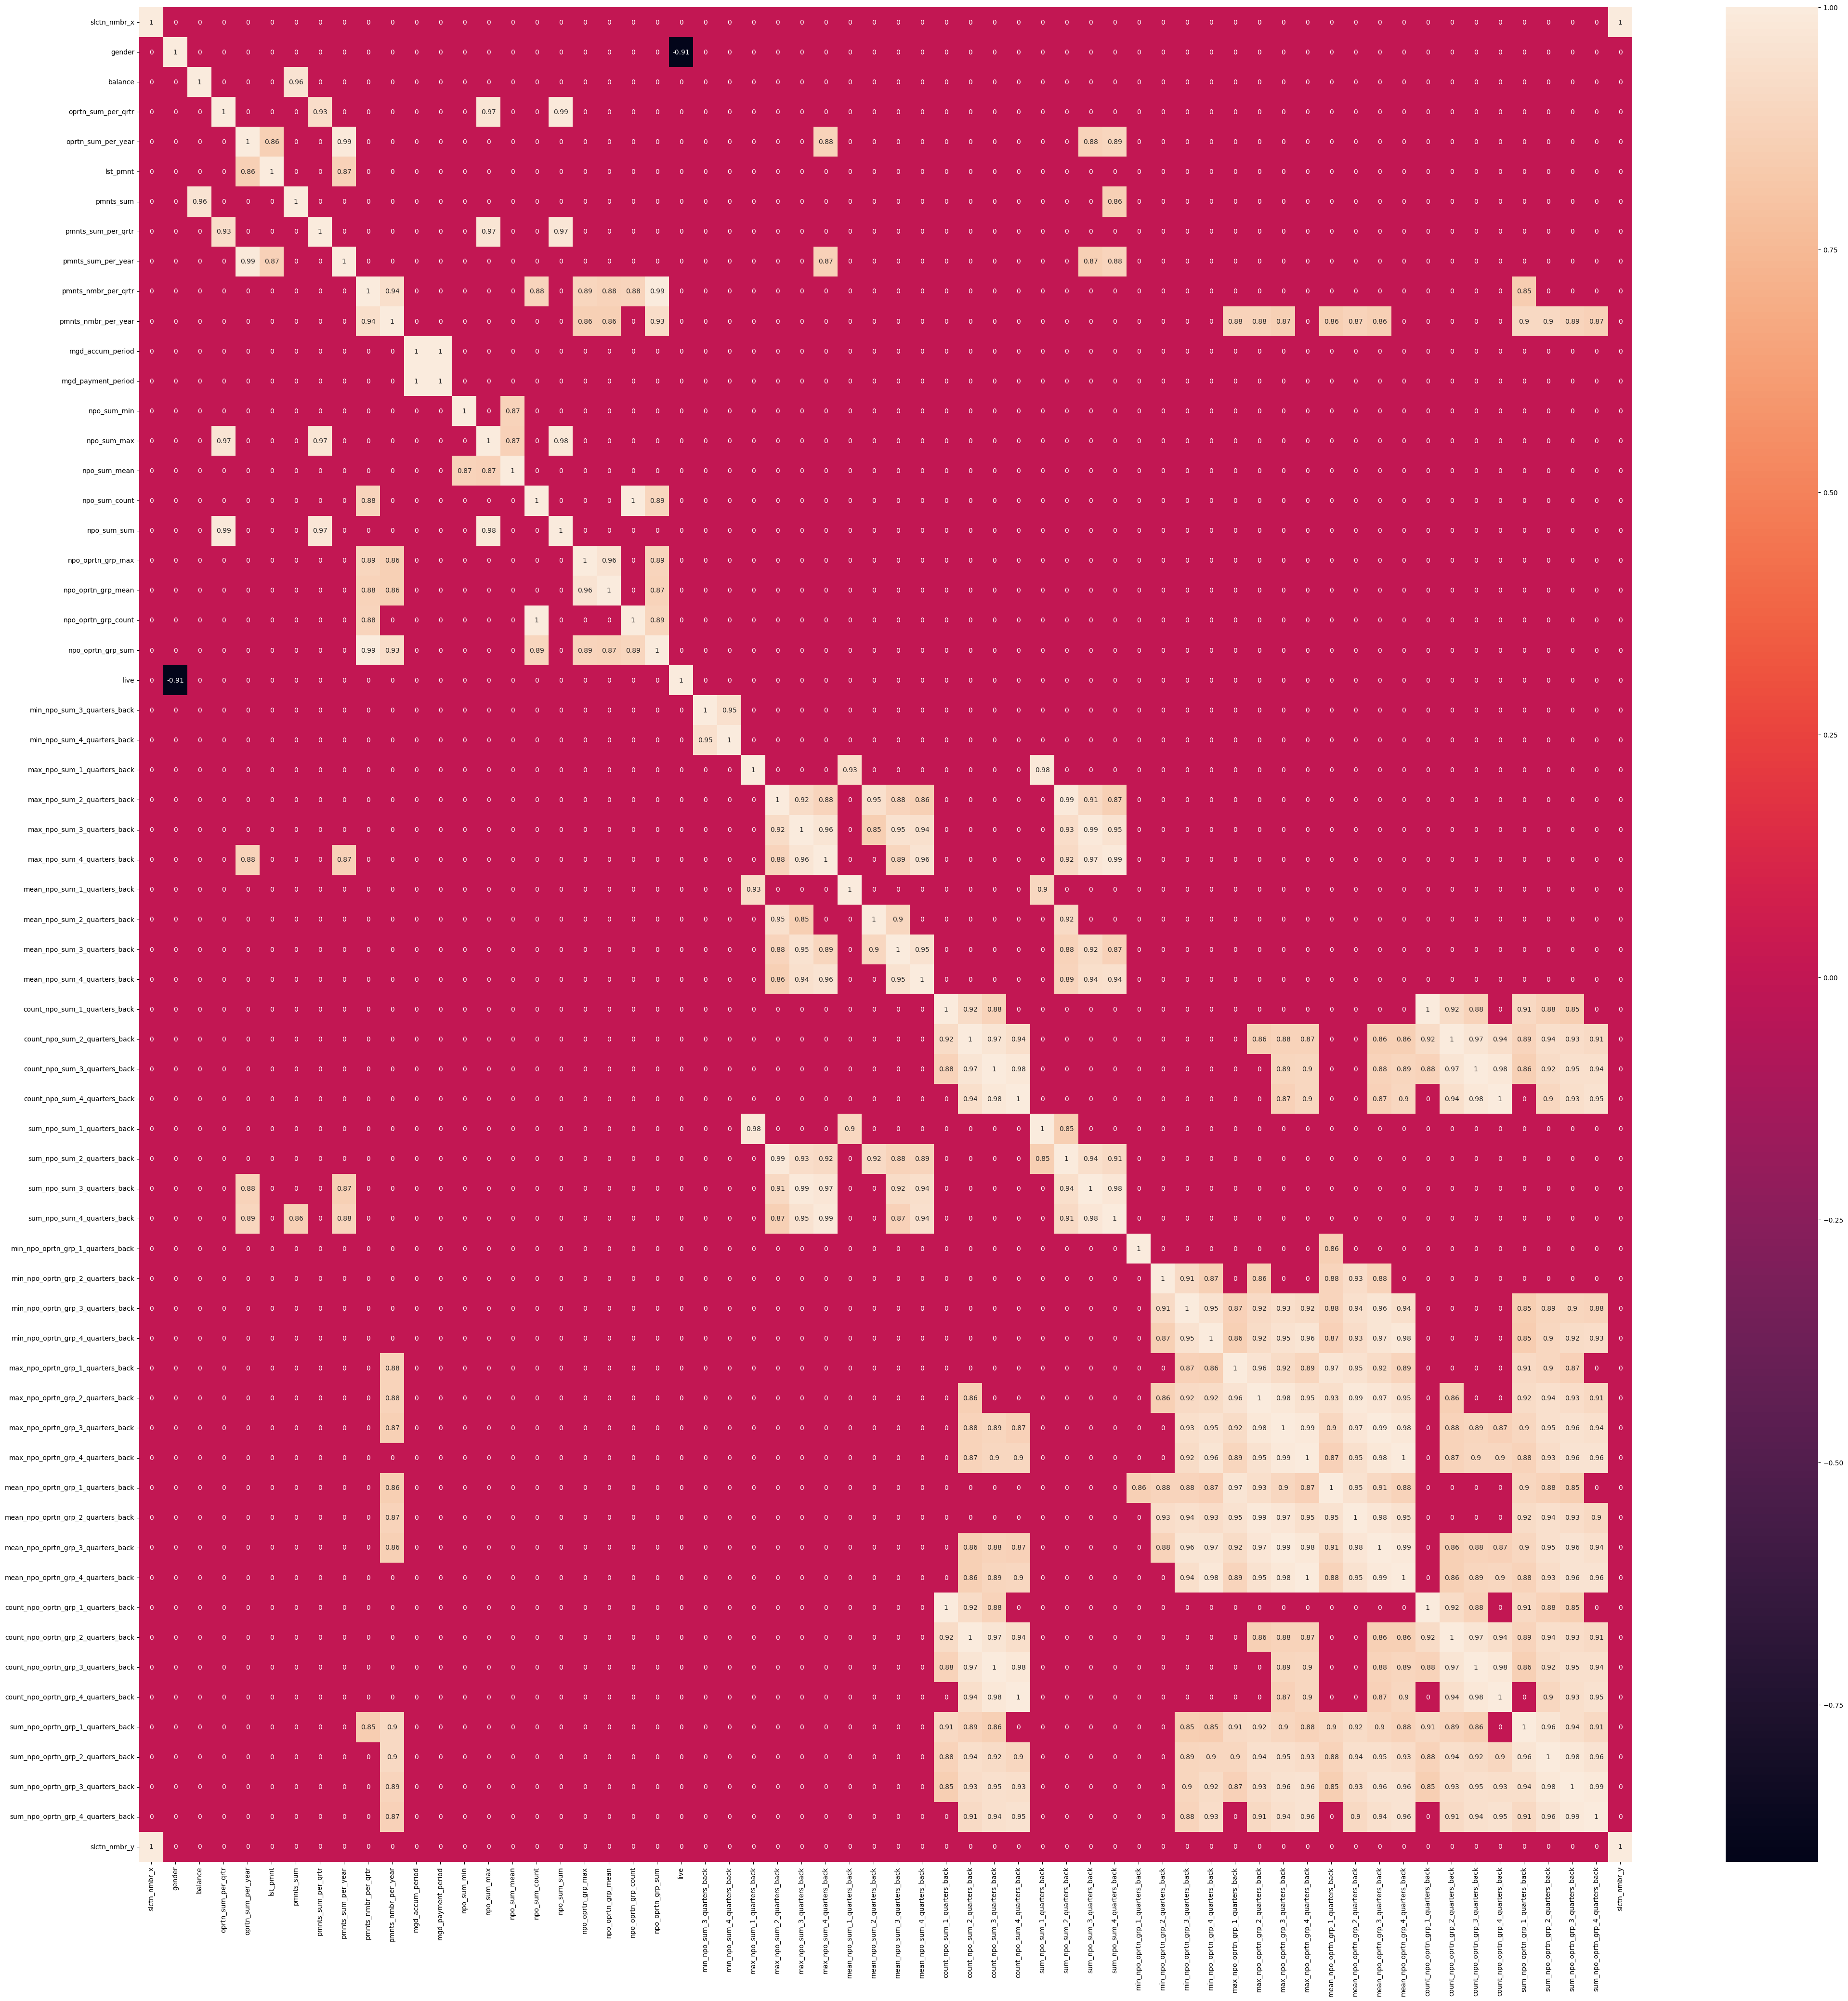

In [16]:
plt.figure(figsize=(50, 50))
sns.heatmap(mat_corr, annot=True);

Удалил столбцы с корреляцией выше 0.9

In [18]:
table_corr = mat_corr.unstack().sort_values()
col_drop = table_corr[(table_corr < 1) & (table_corr > 0.9)].sort_values().index
col_drop = [col_drop[i][1] for i in range(0, col_drop.shape[0], 2)]
col_drop_X = np.unique(col_drop)
data_train_2.drop(col_drop_X, axis=1, inplace=True)

In [19]:
data_train_none.drop(col_drop_X, axis=1, inplace=True)

In [21]:
data_train_2

,slctn_nmbr_x,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt_date,lst_pmnt_date_per_qrtr,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,postal_code,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_mean,npo_sum_count,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_count,quarter_number,quarter_sin,quarter_cos,latitude,longitude,county_name,state_name,key_rate,live,min_npo_sum_1_quarters_back,min_npo_sum_2_quarters_back,min_npo_sum_4_quarters_back,mean_npo_sum_3_quarters_back,sum_npo_sum_1_quarters_back,min_npo_oprtn_grp_1_quarters_back,slctn_nmbr_y,accnt_pnsn_schm,npo_account_id_count_open
1612940,1,0xFD35AC4EAF234E419A561AD7003F534C,0x8FBBB4AACDA99C468B4EBFA074395044,1,2,1993,1993Q2,1,32,16,0,0,20.33,26.37,1993-06-14,1993-06-14,20.32,0.13,20.32,1,-0.00,-0.0,6.04,1.8,1.8,0,0,-1,-1,-1,155569.0,МОСКВА Г,-1,-1,0,0,0.0,20.32,20.320000,1.0,1.0,1.0,1.0,2,1.224647e-16,-1.0,NaN,NaN,None,None,140.0,58.97,0.00,0.000,0.0000,0.000000,0.00,0.0,1,44.0,1
2358279,1,0x6B3DB1FF5A43F742B0B118589845DE22,0x1DD110BD55ECF14C87D17561DB0061D8,1,2,1993,1993Q2,1,54,30,0,0,40.65,257.97,1993-05-31,1993-05-31,40.65,0.47,40.65,1,-0.00,-0.0,14.06,0.0,0.0,0,0,-1,-1,-1,127282.0,МОСКВА Г,-1,-1,0,0,0.0,40.65,40.650000,1.0,1.0,1.0,1.0,2,1.224647e-16,-1.0,55.7522,37.6156,None,Москва,140.0,58.97,0.00,0.000,0.0000,0.000000,0.00,0.0,1,171.0,1
2390991,1,0x2E4397C1288976409535B2CD5537E672,0x710A1F4F54218644809FB5BDDF27D1D0,1,2,1993,1993Q2,1,47,29,29,0,44.72,57.33,1993-06-01,1993-06-30,20.32,0.30,44.71,2,-0.00,-0.0,12.61,1.8,1.8,0,0,-1,-1,-1,115533.0,МОСКВА Г,-1,-1,0,0,0.0,20.32,22.355000,2.0,1.0,1.0,2.0,2,1.224647e-16,-1.0,55.7520,37.6150,None,Москва,140.0,58.97,0.00,0.000,0.0000,0.000000,0.00,0.0,1,37.0,1
1821299,1,0xF47F752FCCD8634196FDE09FB71E32FD,0x6945A34330C0C142BBCCD9B207B1FFAC,1,2,1993,1993Q2,-1,2,8,0,0,20.33,25.92,1993-06-22,1993-06-22,20.32,0.65,20.32,1,-0.00,-0.0,5.59,0.0,0.0,0,0,-1,-1,-1,109369.0,МОСКВА Г,-1,-1,0,0,0.0,20.32,20.320000,1.0,1.0,1.0,1.0,2,1.224647e-16,-1.0,55.7522,37.6156,None,Москва,140.0,71.88,0.00,0.000,0.0000,0.000000,0.00,0.0,1,55.0,1
1349938,1,0xE0C2C941B916CA44B2AA63E70509A684,0x61D7D2464E973746B2CFA82A1F3AE41C,1,2,1993,1993Q2,1,38,3,0,0,20.33,66.81,1993-06-27,1993-06-27,20.32,0.58,20.32,1,-0.00,-0.0,5.83,1.8,1.8,0,0,-1,-1,-1,123459.0,МОСКВА Г,-1,-1,0,0,0.0,20.32,20.320000,1.0,1.0,1.0,1.0,2,1.224647e-16,-1.0,NaN,NaN,None,None,140.0,58.97,0.00,0.000,0.0000,0.000000,0.00,0.0,1,37.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18423,0,0x33BBD943D7FB8C4184F19D1BCDAA17CE,0xA631005056964A2C11EE3F7A23717BF9,1,3,2022,2022Q4,1,45,144,119,31,6304.58,13157.46,2022-08-09,2022-12-06,4117.83,1587.22,13157.45,6,-0.00,-0.0,-0.00,0.0,0.0,-1,0,-1,-1,-1,443065.0,САМАРСКАЯ ОБЛ,1,-1,0,1,0.0,1587.22,2101.520000,3.0,1.0,1.0,3.0,4,-2.449294e-16,1.0,52.1167,36.7833,None,Самарская Область,"7,5",67.57,1749.88,874.940,437.4700,761.430000,6852.87,1.0,0,391.0,1
1264198,3,0x943D2C768A4FB38311E659424435E55F,0xA4ED00505692D0BC11EE20A6DC4A3641,1,1,2022,2022Q4,1,51,173,156,31,2439.02,4878.05,2022-07-11,2022-12-14,813.00,813.00,4878.04,6,-0.00,-0.0,-0.00,0.0,0.0,0,0,1,-1,-1,187602.0,ЛЕНИНГРАДСКАЯ ОБЛ,1,1,1,0,0.0,813.00,813.000000,3.0,1.0,1.0,3.0,4,-2.449294e-16,1.0,59.4533,34.6826,None,Ленинградская Область,"7,5",67.57,813.00,406.500,203.2500,271.000000,2439.00,1.0,3,463.0,1
1766754,2,0x00D6FEEE8D01514DB9CBCADAB5D5D8B2,0x80E2005056AB57EC11E7F6C6A4C28817,3,3,2022,2022Q4,1,40,2181,2155,30,2439.02,9756.10,2017-01-10,2022-12-05,813.00,813.00,58536.58,72,9053.40,-0.0,-0.00,0.0,0.0,-1,-1,1,-1,-1,162626.0,ВОЛОГОДСКАЯ 

# Иследованиt показало, что до 2003 года не было случаев закрытия счета

In [20]:
data_train_2 = data_train_2[data_train_2['year'].astype(int) >= 2002]

# Удалим столбцы, которые характеризуются другой величиной (например квартал мы кодировали синусом)

In [26]:
data_train_2.columns

Index(['slctn_nmbr_x', 'client_id', 'npo_account_id', 'npo_accnts_nmbr',
       'pmnts_type', 'year', 'quarter', 'gender', 'age', 'clnt_cprtn_time_d',
       'actv_prd_d', 'lst_pmnt_rcnc_d', 'oprtn_sum_per_qrtr',
       'oprtn_sum_per_year', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr',
       'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr', 'incm_sum',
       'incm_per_qrtr', 'incm_per_year', 'mgd_accum_period',
       'mgd_payment_period', 'phone_number', 'email', 'lk', 'assignee_npo',
       'assignee_ops', 'postal_code', 'region', 'citizen', 'fact_addrss',
       'appl_mrkr', 'evry_qrtr_pmnt', 'churn', 'npo_sum_min', 'npo_sum_mean',
       'npo_sum_count', 'npo_oprtn_grp_min', 'npo_oprtn_grp_max',
       'npo_oprtn_grp_count', 'quarter_number', 'quarter_sin', 'quarter_cos',
       'latitude', 'longitude', 'county_name', 'state_name', 'key_rate',
       'live', 'min_npo_sum_1_quarters_back', 'min_npo_sum_2_quarters_back',
       'min_npo_sum_4_quarters_back', 'mean_npo_sum_3_quarte

In [21]:
data_train_2.drop(columns=['county_name', 'state_name', 'quarter_number', 'postal_code', 
                         'lst_pmnt_date_per_qrtr', 'frst_pmnt_date', 'quarter'], inplace=True)

data_train_none.drop(columns=['county_name', 'state_name', 'quarter_number', 'postal_code', 
                         'lst_pmnt_date_per_qrtr', 'frst_pmnt_date', 'quarter'], inplace=True)

In [22]:
data_train_2

,slctn_nmbr_x,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_mean,npo_sum_count,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_count,quarter_sin,quarter_cos,latitude,longitude,key_rate,live,min_npo_sum_1_quarters_back,min_npo_sum_2_quarters_back,min_npo_sum_4_quarters_back,mean_npo_sum_3_quarters_back,sum_npo_sum_1_quarters_back,min_npo_oprtn_grp_1_quarters_back,slctn_nmbr_y,accnt_pnsn_schm,npo_account_id_count_open
784155,1,0x32638C73BC0BE242AFCA65C759123AED,0x67B5AAFBE0170A4A8EA14CADA3476DCC,1,2,2002,-1,39,2400,0,1003,6.09,20.37,105.30,0.09,105.30,1,55.52,6.09,20.37,1.8,1.8,0,0,-1,-1,-1,САМАРСКАЯ ОБЛ,1,-1,0,0,0.0,6.09,6.090000,1.0,0.0,0.0,1.0,1.000000e+00,6.123234e-17,NaN,NaN,25.0,71.90,4.91,5.120,5.5550,5.353333,4.91,0.0,1,44.0,1
2455262,1,0x13407A92C5A35E43898BEC08840A8C92,0xCD8F84E9940A88499B5A53E5C61B92C7,1,2,2002,-1,35,2391,0,1003,6.01,20.11,103.96,0.09,103.96,1,54.80,6.00,20.10,1.8,1.8,0,0,-1,-1,-1,САМАРСКАЯ ОБЛ,-1,-1,0,0,0.0,6.00,6.000000,1.0,0.0,0.0,1.0,1.000000e+00,6.123234e-17,54.4333,51.1000,25.0,71.90,4.85,5.055,5.4850,5.283333,4.85,0.0,1,44.0,1
1863591,1,0x0F9F0BC43329184EA978A9DB5898DD44,0x335DA53BAFCA4F45B2D2DD723AAFB513,1,2,2002,1,29,1448,0,1003,4.52,15.12,78.17,0.04,78.17,1,41.20,4.52,15.12,7.5,7.5,0,0,-1,-1,-1,САМАРСКАЯ ОБЛ,-1,-1,0,0,0.0,4.52,4.520000,1.0,0.0,0.0,1.0,1.000000e+00,6.123234e-17,53.1731,48.4744,25.0,58.68,3.65,3.805,4.1225,3.973333,3.65,0.0,1,58.0,1
1509934,1,0x2C7236E0A5C23E42826C85FA57F0A932,0xCFCD314DB40DEE408A2F78C4E2DB1329,1,2,2002,-1,51,1726,281,1445,10.54,35.27,40.65,0.11,121.95,2,156.54,10.54,35.26,7.5,7.5,0,0,-1,-1,-1,БЕЛГОРОДСКАЯ ОБЛ,-1,-1,0,0,0.0,10.54,10.540000,1.0,0.0,0.0,1.0,1.000000e+00,6.123234e-17,50.6563,36.1767,25.0,71.90,8.51,8.870,9.6225,9.273333,8.51,0.0,1,47.0,1
2373669,1,0xA339DCC182A10F43B3AB2332228B098F,0x1EDEB052816A224D8CBD1AC5B316FF8A,1,2,2002,1,65,3206,0,3206,18.25,61.06,40.65,0.28,40.65,1,441.29,18.25,61.05,1.8,1.8,0,0,-1,-1,-1,МОСКВА Г,-1,-1,0,0,0.0,0.00,9.120000,2.0,0.0,0.0,2.0,1.000000e+00,6.123234e-17,NaN,NaN,25.0,58.68,14.73,15.350,16.6525,16.046667,14.73,0.0,1,44.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18423,0,0x33BBD943D7FB8C4184F19D1BCDAA17CE,0xA631005056964A2C11EE3F7A23717BF9,1,3,2022,1,45,144,119,31,6304.58,13157.46,4117.83,1587.22,13157.45,6,-0.00,-0.00,-0.00,0.0,0.0,-1,0,-1,-1,-1,САМАРСКАЯ ОБЛ,1,-1,0,1,0.0,1587.22,2101.520000,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,52.1167,36.7833,"7,5",67.57,1749.88,874.940,437.4700,761.430000,6852.87,1.0,0,391.0,1
1264198,3,0x943D2C768A4FB38311E659424435E55F,0xA4ED00505692D0BC11EE20A6DC4A3641,1,1,2022,1,51,173,156,31,2439.02,4878.05,813.00,813.00,4878.04,6,-0.00,-0.00,-0.00,0.0,0.0,0,0,1,-1,-1,ЛЕНИНГРАДСКАЯ ОБЛ,1,1,1,0,0.0,813.00,813.000000,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,59.4533,34.6826,"7,5",67.57,813.00,406.500,203.2500,271.000000,2439.00,1.0,3,463.0,1
1766754,2,0x00D6FEEE8D01514DB9CBCADAB5D5D8B2,0x80E2005056AB57EC11E7F6C6A4C28817,3,3,2022,1,40,2181,2155,30,2439.02,9756.10,813.00,813.00,58536.58,72,9053.40,-0.00,-0.00,0.0,0.0,-1,-1,1,-1,-1,ВОЛОГОДСКАЯ ОБЛ,1,1,1,0,0.0,813.00,1797.537500,4.0,0.0,1.0,4.0,-2.449294e-16,1.000000e+00,58.6304,38.2367,"7,5",67.57,813.00,813.000,813.0000,813.000000,2439.00,1.0,2,10.0,2
179494,0,0xFA6287BAAE2C1F4A993BB356BF30216B,0xB45008E69B33DA4D9DD924FC3C1475DE,1,1,2022,1,45,4038,4013,340,50651.51,50651.51,5761.99,7943.96,1299101.32,123,425629.57,-0.00,-0.00,0.0,0.0,-1,0,1,-1,-1,МОСКВА Г,1,1,1,0,0.0,1732.22,15076.710000,4.0,1.0,1.0,4.0,-2.449294e-16,1.0

In [23]:
data_train_none

,slctn_nmbr_x,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,gender,age,clnt_cprtn_time_d,actv_prd_d,lst_pmnt_rcnc_d,oprtn_sum_per_qrtr,oprtn_sum_per_year,frst_pmnt,lst_pmnt,pmnts_sum,pmnts_nmbr,incm_sum,incm_per_qrtr,incm_per_year,mgd_accum_period,mgd_payment_period,phone_number,email,lk,assignee_npo,assignee_ops,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,churn,npo_sum_min,npo_sum_mean,npo_sum_count,npo_oprtn_grp_min,npo_oprtn_grp_max,npo_oprtn_grp_count,quarter_sin,quarter_cos,latitude,longitude,key_rate,live,min_npo_sum_1_quarters_back,min_npo_sum_2_quarters_back,min_npo_sum_4_quarters_back,mean_npo_sum_3_quarters_back,sum_npo_sum_1_quarters_back,min_npo_oprtn_grp_1_quarters_back,slctn_nmbr_y,accnt_pnsn_schm,npo_account_id_count_open
846642,0,0x1BEA3D28585CE649AAC4CF8B03A1CA67,0x0000132B2D126446B3E105530BA834B9,1,1,2022,-1,54,5434,5410,63,13573.98,69661.19,2666.66,5456.28,593871.29,131,267992.58,-0.00,-0.00,0.0,0.0,-1,0,1,-1,-1,None,-1,1,0,0,NaN,3406.13,4524.653333,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,NaN,NaN,"7,5",77.77,4452.60,4802.680,3797.8250,5553.937778,24406.92,1.0,0,351.0,1
2540626,2,0x88163453D28354468023118E0E27D3A4,0x00001D0D26AAAE4D84D565638EA2C918,3,2,2020,1,36,4788,0,4788,3.59,3.59,317.07,317.07,317.07,1,135.80,3.59,3.59,0.1,0.1,-1,-1,-1,-1,-1,НИЖЕГОРОДСКАЯ ОБЛ,-1,-1,0,0,NaN,0.44,1.790000,2.0,0.0,0.0,2.0,-2.449294e-16,1.000000e+00,56.4744,43.5414,"4,25",66.49,0.44,0.440,0.4375,0.440000,0.44,0.0,2,4.0,3
1731529,0,0x54C04405FA764949A5FD0BA8F5710249,0x00004DC151146F4395ECA6CCFA37B20D,1,3,2022,-1,55,2469,2405,31,5212.50,20091.67,1101.29,1287.52,101885.88,78,13933.13,-0.00,-0.00,0.0,0.0,-1,0,-1,-1,-1,БАШКОРТОСТАН РЕСП,1,1,0,1,NaN,1287.52,1737.496667,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,56.2353,68.7697,"7,5",77.77,549.96,786.330,1124.6400,1653.236667,5539.21,1.0,0,351.0,1
1686753,2,0x013054CD1830FC45A0FA175DA63AE818,0x00005427FC2C2B44953D64566BECB170,1,2,2021,-1,35,5680,461,5191,205.03,205.03,154.47,154.47,2471.54,16,2320.43,205.03,205.03,4.0,4.0,-1,-1,-1,-1,-1,НИЖЕГОРОДСКАЯ ОБЛ,1,1,0,0,NaN,21.55,102.515000,2.0,0.0,0.0,2.0,-2.449294e-16,1.000000e+00,56.6428,43.3936,"8,5",74.51,176.42,173.025,166.4975,169.720000,176.42,0.0,2,0.0,1
1268203,0,0xB2CE3FAFF0AE04419D280D2C0932FD1F,0x0000719668D179449B3FE803661A5C83,1,2,2007,1,46,1026,797,29,1319.22,-7768.66,1404.98,444.09,9087.88,28,1186.26,-0.00,-0.00,0.0,0.0,-1,0,-1,-1,-1,None,-1,-1,0,1,NaN,366.85,439.736667,3.0,1.0,1.0,3.0,1.000000e+00,6.123234e-17,NaN,NaN,10.5,61.46,328.75,314.205,248.4525,328.861944,1767.61,0.0,0,354.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511376,0,0x195A2B9DBC047C4597A2673DA669FE41,0xFFFDE0A53E7583448787A634EB5FD1D2,2,1,2022,1,66,5456,5438,30,9177.94,38999.38,2828.30,2833.48,434566.05,185,216437.24,-0.00,-0.00,0.0,0.0,-1,0,1,-1,-1,ХАНТЫ-МАНСИЙСКИЙ АО,1,1,0,1,NaN,643.97,3059.310000,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,61.0833,72.7000,"7,5",67.57,3123.12,2953.290,2323.0975,3313.490000,11812.66,1.0,0,351.0,1
1364025,1,0x12C6A29E1079E34382B2EAC290780989,0xFFFE4B5CBCF637428BB810D4EA92A6A6,3,1,2022,1,57,6310,6290,32,5222.05,19769.75,338.96,1963.56,196428.73,400,97618.96,-0.00,-0.00,0.0,0.0,0,0,1,-1,-1,МОСКОВСКАЯ ОБЛ,1,-1,0,1,NaN,1467.48,1740.680000,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,52.9378,34.9925,"7,5",67.57,1502.62,1556.000,1505.6875,1616.407778,4732.46,1.0,1,52.0,1
986346,0,0x2DA604A4EAC8AC4FBA4E186D026DCDC9,0xFFFF57AF7B56DE4891B4CD4E78A5B892,1,3,2022,-1,51,1385,1308,29,8259.36,44318.06,981.53,3578.66,149020.37,48,7071.69,-0.00,-0.00,0.0,0.0,-1,0,1,-1,-1,ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО,1,1,0,1,NaN,1040.15,2753.113333,3.0,1.0,1.0,3.0,-2.449294e-16,1.000000e+00,61.0833,72.7000,"7,5",77.77,1973.45,2306.345,2307.1750,3504.875556,18059.08,1.0,0,351.0,1
2212431,1,0x4377E405B57A704DB4BA8AB129622DB7,0xFFFF5DA61B60574194D4B

In [29]:
data_train_2.to_parquet('/kaggle/working/data_train_fin.parquet', index=False)

In [24]:
data_train_none.to_parquet('/kaggle/working/data_test_none.parquet', index=False)